## QA of h3 calculations vs rasters calculations

Notebook for QAing the h3 calculations performed in LG using h3 vs the values that we can obtain using the raster data.

This notebook contains two main parts:

    1. QA using satelligence calculations, and once we are sure of the error that we are getting between raster and h3 conversion we can:
    2. QA between raster values for indicators and h3 calculations.
    
We will be using Aceh, Indonesia as sample location, calculating the impact for each supplier inside this location. 


NOTE: Potentially, we can also explore how different geometries resolutions may affect the accuracy of teh result. 



In [1]:
#import libraries

import numpy as np
import geopandas as gpd
import pandas as pd

import h3
import h3pandas
from h3ronpy import raster
import rasterio as rio
from rasterio import mask
from rasterstats import zonal_stats #gen_zonal_stats, gen_point_query, 

from matplotlib import pyplot
%matplotlib inline

import folium


import argparse

import cv2
import numpy as np

In [2]:
FILE_DIR = "../../datasets/raw/h3_raster_QA_calculations"

In [26]:
!ls $FILE_DIR/core_indicators/materials/palm_oil_harvest_area_ha_clip_v2.tif

palm_oil_harvest_area_ha_clip.tif.aux.xml
palm_oil_harvest_area_ha_clip_v2.tif
palm_oil_harvest_area_ha.tif.aux.xml
palm_oil_production_t_clip.tif
palm_oil_production_t_clip_v2.tif.aux.xml
palm_oil_production_t.tif.aux.xml


### 1. QA using satelligence data - RASTER:

Calculate deforestation and carbon impacts in mill locations in Aceh using satelligence data for raster calculations.

In [13]:
#open mill locations

#gdf = gpd.read_file(f"{FILE_DIR}/satelligence data/AcehMills_indicators.gpkg")
#gdf.head()

In [14]:
#buffer = 50000

def get_buffer(gdf, buffer, save=True, save_path='./'):
    
    if gdf.crs and gdf.crs != 'EPSG:3857':
        print('Reprojecting to EPSG:3857')
        #reproject
        gdf_reprojected = gdf.to_crs("EPSG:3857")
    else:
        print('Set a valid projection to the vector layer')

    gdf_buffer = gdf_reprojected.buffer(buffer)

    gdf_buffer_reprojected = gdf_buffer.to_crs('EPSG:4326')
    if save:
        gdf_buffer_reprojected.to_file(save_path)
    return gdf_buffer_reprojected

def get_buffer_stats(
    raster_path,
    vector_path,
    buffer=50000,
    stat_='sum',
    all_touched= True,
    column_name ='estimated_val'
    ):
    
    """
    Function to obtain raster stats in abuffer geometry.
    The function calculates first the buffer from the point vector file and then calculates the 
    raster stadistics inside the geometry.
    
    Inputs
    ------------------------
    raster_path: Raster path for retrieving the statdistics in EPSG:4326 projection.
    vector_path: Vector path for calculating the stadistics. The layer should contain a point geometry
    buffer: Radio distance in meters for computting the buffer geometry.
    stat_: Stadistics to compute using the zonal stadistics.
    all_touched: condition for the zonal stadistics. Used True as default.
    
    Output
    -----------------------
    
    gdf with stadistics
    
    """
    gdf = gpd.read_file(f"{vector_path}")
    
    gdf_buffer = get_buffer(gdf, buffer, save=False, save_path='./')
    
    #if gdf.crs and gdf.crs != 'EPSG:3857':
    #    print('Reprojecting to EPSG:3857')
    #    #reproject
    #    gdf_reprojected = gdf.to_crs("EPSG:3857")
    #else:
    #    print('Set a valid projection to the vector layer')

    ##get buffer

    #gdf_buffer = gdf_reprojected.buffer(buffer)

    #reproject back to EPSG4326 as raster data should be provided in this projection

    #gdf_buffer_reprojected = gdf_buffer.to_crs('EPSG:4326')

    stadistics = []
    for geom in gdf_buffer:
        stats = zonal_stats(
            geom,
            raster_path,
            stats = stat_,
            all_touched = all_touched
        )
        stat_sum = stats[0]['sum']
        stadistics.append(stat_sum)
    #add stats in dataframe
    gdf[column_name]=stadistics
    return gdf

def convert_rasterToH3(raster_path, resolution=6):
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

        gdf.plot('value')
        gdf['h3index'] = gdf['h3index'].apply(hex)
    return gdf
    
def get_h3_vector_statistics(raster_path, vector_path, column='estimated', resolution=6):
    """
    Funtion to convert raster to h3 for a given resolution. The same function will obtain the sum of 
    all the values for a given geometry.
    
    Inputs
    ---------------
    raster_path: Path to raster layer to convert to a given h3 resolution.
    vector_path: Path to vector layer with geometris to obtain the h3 zonal stadistics.
    column: name of the output column with the zonal stadistics.
    resolution: H3 resolution
    
    Output
    --------------
    gdf: GeoDataFrame with zonal statidtics
    """
    #with rio.open(raster_path) as src:
    #    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)
#
    #    gdf.plot('value')
    #    gdf['h3index'] = gdf['h3index'].apply(hex)
    gdf = convert_rasterToH3(raster_path, resolution=resolution)

    gdf_vector = gpd.read_file(vector_path)
    #clean_gdf = gdf_vector[['gfw_fid',column,'geometry']]
    
    _sum_calculated = []
    for i, row in gdf_vector.iterrows():
        filtered_gdf = gdf_vector[i:i+1]
        #convert to h3
        h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
        #h3_gdf = h3_gdf.reset_index().rename(columns={'h3_polyfill':'h3index'})
        h3index_list = [f'0x{h3index}' for h3index in h3_gdf.index]
        #filter gdf by list and get value
        _sum = gdf[gdf['h3index'].isin(h3index_list)]['value'].sum()
        _sum_calculated.append(_sum)
        
    gdf_vector[column] = _sum_calculated
    return gdf_vector



In [19]:
#read raster/tif file
mills = f"{FILE_DIR}/satelligence data/AcehMills_indicators.gpkg"
def_tif = f"{FILE_DIR}/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01.tif"
carb_tif = f"{FILE_DIR}/satelligence data/rasters_indicators/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif"

,h3index,raster_area,geometry,h3_area,ratio
0,866422127ffffff,85.198303,"POLYGON ((98.01018 8.01958, 98.01317 8.05624, ...",43.458576,0.510087
1,86642212fffffff,85.198303,"POLYGON ((97.94605 8.02463, 97.94903 8.06129, ...",43.463417,0.510144
2,866422147ffffff,85.198303,"POLYGON ((97.81777 8.03470, 97.82074 8.07137, ...",43.472617,0.510252
3,86642214fffffff,85.198303,"POLYGON ((97.75362 8.03972, 97.75658 8.07639, ...",43.476977,0.510303
4,86642216fffffff,85.198303,"POLYGON ((97.78126 7.98220, 97.78422 8.01887, ...",43.471003,0.510233


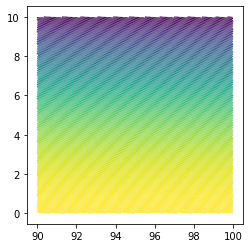

In [20]:
area_h3_gdf = convert_rasterToH3("../../datasets/raw/h3_raster_QA_calculations/h3_area_correction/8_Areakm_clip.tif", resolution=6)
gdf_buffer50km = gpd.read_file(f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp")

area_h3_gdf['h3index'] = [row['h3index'].split('x')[1] for i,row in area_h3_gdf.iterrows()]
area_h3_gdf['h3_area'] = [h3.cell_area(row['h3index'], unit='km^2') for i,row in area_h3_gdf.iterrows()]
area_h3_gdf = area_h3_gdf.rename(columns={'value':'raster_area'})
area_h3_gdf['ratio'] = area_h3_gdf['h3_area']/area_h3_gdf['raster_area']
area_h3_gdf.head()


In [12]:
def get_zonal_stats_correction_factor(raster_path='./',
                                      corrected_area_gdf=area_h3_gdf,
                                      resolution=6,
                                      buffer_gdf=gdf_buffer50km,
                                      formula=1):
    gdf = convert_rasterToH3(raster_path,resolution=resolution)
    gdf['h3index'] = [row['h3index'].split('x')[1] for i,row in gdf.iterrows()]
    gdf['h3_ratio'] = [list(corrected_area_gdf[corrected_area_gdf['h3index']==row['h3index']]['ratio'])[0] for i, row in gdf.iterrows()]
    
    gdf['corrected_value'] = gdf['value']*gdf['h3_ratio']*formula
    
    geom_sum_ha = []
    for i, row in buffer_gdf.iterrows():
        filtered_gdf = buffer_gdf[i:i+1]
        h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)

        h3index_list = list(h3_gdf.index)
        gdf_filtered = gdf[gdf['h3index'].isin(h3index_list)]
        sum_ = gdf_filtered['corrected_value'].sum()
        geom_sum_ha.append(sum_)
    
    buffer_gdf['sum'] = geom_sum_ha
    
    return buffer_gdf

In [17]:
#calculate deforested area
!gdal_calc.py --calc "A*6.69019042035408517*6.69019042035408517* 0.0001" --format GTiff --type Float32 --NoDataValue 0.0 -A "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01.tif" --A_band 1 --outfile "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 96.. 96.. 96.. 96.. 

In [20]:
#preprocess carbon datasets before computing the carbon emissions

##1. downsample carbon layer to same resolution as deforestation area file
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 6e-05 6e-05 -r near -q -te 94.99998 2.1 98.29998 6.10002 -te_srs EPSG:4326 -multi -of GTiff "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/AboveGroundBiomass_GLO_2001-01-01-2002-01-01.tif" '../../datasets/raw/h3_raster_QA_calculations/preprocessed/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_downsample.tif'


In [22]:
#get the downsampled carbon layer
!gdal_calc.py --calc "A*B" --format GTiff --type Float32 --q -A '../../datasets/raw/h3_raster_QA_calculations/preprocessed/AboveGroundBiomass_GLO_2001-01-01-2002-01-01_downsample.tif' --A_band 1 -B "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif" --outfile '../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample.tif'

In [26]:
%%time
carb_tif_downsampled = '../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample.tif'
#gdf = get_buffer_stats(def_tif, mills, buffer=50000, stat_='sum', all_touched= True, column_name ='def_true')
#gdf = get_buffer_stats(def_tif, mills, buffer=50000, stat_='sum', all_touched= False, column_name ='def_false')
gdf = get_buffer_stats(carb_tif_downsampled, mills, buffer=50000, stat_='sum', all_touched= False, column_name ='carb_false')

#convert to area deforested
#gdf['def_true'] = gdf['def_true']*6.69019042035408517*6.69019042035408517* 0.0001
#gdf['def_false'] = gdf['def_false']*6.69019042035408517*6.69019042035408517* 0.0001

gdf.head()


Reprojecting to EPSG:3857
CPU times: user 1min 34s, sys: 1min 53s, total: 3min 27s
Wall time: 3min 38s


,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,longitude,...,confidence,alternativ,gfw_area__,gfw_geosto,deforestation,high_biodiversity_area,protected_area_loss,carbon,geometry,carb_false
0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,98.02851,...,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,4.099892144030757,57812.37323319753,POINT (98.02851 2.24508),57793.746094
1,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,97.99571899999999,...,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,11.27470339608458,74432.2796810086,POINT (97.99572 2.31416),74415.992188
2,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,97.956667,...,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,14.50180190683368,95543.40760696075,POINT (97.95667 2.39111),95535.335938
3,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,97.91529,...,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,22.19581347407044,109557.3760590317,POINT (97.91529 2.43594),109531.187500
4,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,98.06502,...,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,11.4179310692385,104970.0756673934,POINT (98.06502 2.45678),104951.414062


In [27]:
#export to csv
gdf = gdf[['gfw_fid','mill_name','deforestation', 'carbon','carb_false','geometry']]
gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_all_touched_false.csv")

### 2. QA using satelligence data - H3:

Calculate deforestation and carbon impacts in mill locations in Aceh using satelligence data in h3 format. Explore differences vs raster calculations and seek ways of mitigating the potential error.

#### 2.1 Deforestation as a count

 1. Downsample the deforestation by counting deforested pixels
 2. Translate downsampled result to h3
 3. Compute deforestation in area

In [7]:
!gdal_calc.py --calc "A*1" --format GTiff --q --type Float32 --NoDataValue 0.0 -A "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01.tif" --A_band 1 --outfile "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif"

In [8]:
## as the deforestation is represented with a 1, the sum will be equal to the count
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -q -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif" "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01_downsample_count.tif"

In [21]:
gdf_filtered = gdf[['gfw_fid','deforestation', 'carbon', 'geometry' ]]

#get vector buffer for computing the h3 statistics
gdf_filtered_buffer = get_buffer(
    gdf_filtered,
    50000,
    save=True,
    save_path=f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp")
gdf_filtered_buffer.head()

Reprojecting to EPSG:3857


,gfw_fid,deforestation,carbon,geometry
0,706,349.5068535490499,57812.37323319753,POINT (98.02851 2.24508)
1,717,444.9278149230584,74432.2796810086,POINT (97.99572 2.31416)
2,264,552.3038111406324,95543.40760696075,POINT (97.95667 2.39111)
3,738,621.1470874150178,109557.3760590317,POINT (97.91529 2.43594)
4,1516,600.0120538952435,104970.0756673934,POINT (98.06502 2.45678)


,FID,geometry,def_estimated_count
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",149596.56250
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",192274.68750
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",250899.25000
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",316392.87500
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",246846.03125


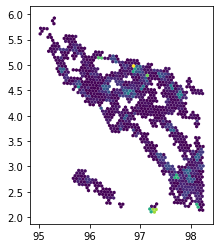

In [28]:
gdf_count_h3 = get_h3_vector_statistics(
    "../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01_downsample_count.tif",
    f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp",
    column='def_estimated_count',
    resolution=6)
#save
gdf_count_h3.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/deforestation_count.csv")
gdf_count_h3.head()

In [17]:
#gdf_buffer50km = gpd.read_file(f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp")
#
#geom_sum_ha = []
#for i, row in gdf_buffer50km.iterrows():
#    filtered_gdf = gdf_buffer50km[i:i+1]
#    h3_gdf = filtered_gdf.h3.polyfill_resample(6)
#    
#    #h3index_list = [f'0x{h3index}' for h3index in h3_gdf.index]
#    h3_list = h3_gdf.index
#    hex_area = []
#    for h in h3_gdf.index:
#        area_ha = h3.cell_area(h, unit='km^2')*100
#        hex_area.append(area_ha)
#    #print(sum(hex_area))
#    #h3_area_sum = sum(hex_area)
#    #geom_sum_ha.append(h3_area_sum)
#    break
#h3_gdf.head()

#### 2.2 Deforestation as a sum

 1. Downsample the deforestation area raster by summing deforested pixels
 2. Translate downsampled result to h3
 3. Compute deforestation in area

In [9]:
##Downsample the deforestation area raster by summing the deforested pixels
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -q -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif" "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha_sum.tif"

,FID,geometry,def_estimated_sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",669.573853
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",860.595276
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",1122.991089
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",1416.131958
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",1104.849487


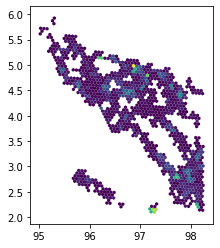

In [39]:
gdf_sum_h3 = get_h3_vector_statistics(
    "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha_sum.tif",
    f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp",
    column='def_estimated_sum',
    resolution=6)
#save
gdf_sum_h3.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/deforestation_sum.csv")
gdf_sum_h3.head()

#### 2.3 Deforestation area corrected

Based on the two analysis above (ingestion of deforestation as count or as area), we can determine that there isn't that much difference in the election of the method selected to replicate the raster calculations. However, there is an importat area correction that needs to be done to either of theingestion process in order to mitigate the h3 error generated during the raster to h3 translation. Therefore, we are going to try to:

- generate h3 file with pixel area/ h3 area ratio for correcting the calculations
- ingest the data as count * pixel area
- correct calculations and get zonal statistics


In [1]:
#clip area raster by Ache, Indonesia extension
!gdal_translate -projwin 90.0 10.0 100.0 0.0 -q -a_nodata 0.0 -of GTiff "../../datasets/raw/h3_raster_QA_calculations/h3_area_correction/8_Areakm.tif" "../../datasets/raw/h3_raster_QA_calculations/h3_area_correction/8_Areakm_clip.tif"

,FID,geometry,sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",330.380831
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",424.847104
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",554.695722
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",699.823710
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",545.733333


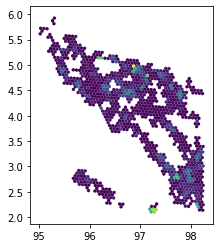

In [30]:
def_count_h3_gdf = get_zonal_stats_correction_factor(raster_path="../../datasets/raw/h3_raster_QA_calculations/satelligence data/rasters_indicators/Deforestation_IDN_2021-01-01-2022-01-01_downsample_count.tif",
                                      corrected_area_gdf=area_h3_gdf,
                                      resolution=6,
                                      buffer_gdf=gdf_buffer50km,
                                      formula=6.69019042035408*6.69019042035408* 0.0001)
def_count_h3_gdf.head()

#### 2.4. Carbon calculations

Do the same for the carbon calculations:

In [9]:
## upsample the carbon_loss_T for ingesting
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff '../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample.tif' '../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample_sum_v2.tif'

Creating output file that is 40P x 48L.
Processing ../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


,FID,geometry,carb_estimated_sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",111082.390625
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",146149.578125
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",197099.796875
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",253342.390625
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",193674.203125


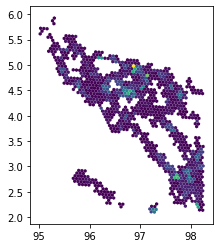

In [31]:
carbon_gdf_no_area = get_h3_vector_statistics(
    '../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample_sum_v2.tif',
    f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp",
    column='carb_estimated_sum',
    resolution=6)
carbon_gdf_no_area.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/carbon_loss_T_downsample_sum_no_corrected_h3.csv")
carbon_gdf_no_area.head()

,FID,geometry,sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",54810.309030
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",72152.463108
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",97365.938479
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",125210.720521
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",95673.065457


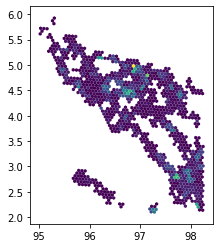

In [19]:
carbon_gdf = get_zonal_stats_correction_factor(
'../../datasets/raw/h3_raster_QA_calculations/preprocessed/carbon_loss_T_downsample_sum_v2.tif')
carbon_gdf.head()

In [20]:
carbon_gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/carbon_loss_T_downsample_sum.csv")

## LG core indicators

Calculate impact associated with palm oil consumption in the different locations. We assume that the purchased volume is always 1T.

## Land Use

Land impact = land impact(ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))

In [33]:
#get sum of harvest area
#%%time
oilp_harvest_area = f"{FILE_DIR}/core_indicators/materials/palm_oil_harvest_area_ha_clip_v3.tif"
oilp_production = f"{FILE_DIR}/core_indicators/materials/palm_oil_production_t_clip_v3.tif"
#mills
#gdf = get_buffer_stats(oilp_production, mills, stat_='sum', all_touched= True, column_name ='production_true')
#gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/production_true.csv")
##
#gdf.head()

,FID,geometry,sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",43619.566752
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",47821.533207
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",51549.914197
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",52289.701241
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",51958.511047


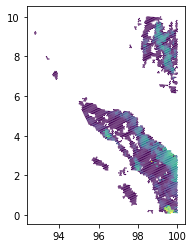

In [62]:
#get area corrected zonal statstics
h3_gdf = get_zonal_stats_correction_factor(raster_path=oilp_harvest_area,
                                      corrected_area_gdf=area_h3_gdf,
                                      resolution=6,
                                      buffer_gdf=gdf_buffer50km,
                                      formula=1)
h3_gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/oilp_harvest_area_ha.csv")
#h3_gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/oilp_production_p.csv")
h3_gdf.head()

,FID,geometry,h3_estimated_sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",1259195.750
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",1324397.125
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",1415491.375
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",1405421.125
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",1419992.750


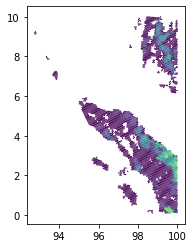

In [35]:
#compare against the no area corrected

h3_gdf = get_h3_vector_statistics(
    oilp_production,
    f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp",
    column='h3_estimated_sum',
    resolution=6)
#h3_gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/oilp_harvest_area_no_corrected_h3.csv")
h3_gdf.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/oilp_prod_no_corrected_h3.csv")
h3_gdf.head()

## LG deforestation risk:

Based on the LG v0.1 methodolofy, the calculation of the deforestation risk will be calculated by buffering the production map using a radius kernel  prior to use it as weighted layer in order to capture areas nearby to production regions. The impact factor is calculated as the production weighted average within the sourcing geometry using the buffered production map.

The formula is:

        Ic,g = IFgb * Ifarm-land c,g / sum(harvest area)
        
    where IFgb is the impact factor associated with the buffered sourcing geometry gb; and harvest area (ha) is the total harvest area of all the crops in the buffered sourcing location gb.
    
    IFgb = kernel Def pixel * Production pixel / sumProdArea
    
Calculations for the area of interest where made in notebook 10_Met_v0.1_results.  



In [21]:
filename = "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha_sum.tif"
out_file = "../../datasets/raw/h3_raster_QA_calculations/preprocessed/Deforestation_IDN_2021-01-01-2022-01-01_area_ha_sum_kernnel.tif"
radius = 50

with rio.open(filename) as src:
    meta = src.meta.copy()
    transform = src.transform
    arr = src.read(1)
    orig_crs = src.crs
    
#if orig_crs.is_geographic:
#    y_size_km = -transform[4] / 1000
#    
#radius_in_pixels = int(radius / y_size_km)



In [4]:
#as I'm having issues with memory, I'm going to use a randon kernel as I just want to test the difference between the raster and h3 calculations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(10000,
                                                            10000))

In [5]:
res_buff = cv2.filter2D(arr, ddepth=-1, kernel=kernel) / np.sum(kernel)

In [6]:
out_file = "../../datasets/raw/h3_raster_QA_calculations/preprocessed/def_area_kernnel.tif"
with rio.open(out_file, "w", **meta) as dest:
    dest.write(res_buff[np.newaxis, :])

In [27]:
#get zonal statistics in geometries with raster with kernnel corrected and no corrected by area

#no corrected by area

gdf_lg_def = get_buffer_stats(
    "../../datasets/raw/h3_raster_QA_calculations/preprocessed/def_area_kernnel.tif",
    mills,
    buffer=50000,
    stat_='sum',
    all_touched= True,
    column_name ='lg_def_val_noarea'
    )

gdf_lg_def.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/lg_def_ha.csv")

gdf_lg_def.head()

Reprojecting to EPSG:3857


,gfw_fid,uml_id,group_name,parent_com,mill_name,rspo_statu,rspo_type,date,latitude,longitude,...,confidence,alternativ,gfw_area__,gfw_geosto,deforestation,high_biodiversity_area,protected_area_loss,carbon,geometry,lg_def_val_noarea
0,706,PO1000004155,IBRIS PALM,DELIMA MAKMUR,DELIMA MAKMUR,Not RSPO Certified,None,2021-07-14,2.24508,98.02851,...,1-Fully Verified,LAE TANGGA,0,256170af-2d4f-4a5b-a417-b981205849be,349.5068535490499,200.138293908663,4.099892144030757,57812.37323319753,POINT (98.02851 2.24508),165.419296
1,717,PO1000004167,ASTRA AGRO LESTARI,PERKEBUNAN LEMBAH BHAKTI,PERKEBUNAN LEMBAH BHAKTI 1,Not RSPO Certified,None,2021-07-14,2.314164,97.99571899999999,...,1-Fully Verified,None,0,b2d76be0-1ace-7a54-8e5e-74bb01111787,444.9278149230584,295.5592552826714,11.27470339608458,74432.2796810086,POINT (97.99572 2.31416),193.413086
2,264,PO1000001775,SOCFIN,SOCFIN INDONESIA,LAE BUTAR,RSPO Certified,"RSPO Certified, IP",2021-07-14,2.391111,97.956667,...,1-Fully Verified,None,0,aff58ced-c18c-a5d8-d084-eb5a6a74416b,552.3038111406324,400.8360709155834,14.50180190683368,95543.40760696075,POINT (97.95667 2.39111),218.861633
3,738,PO1000004197,UNKNOWN,NAFASINDO,NAFASINDO,Not RSPO Certified,None,2021-07-14,2.43594,97.91529,...,1-Fully Verified,None,0,3cee289b-cdd6-a33d-e0f6-15ea8e7423fa,621.1470874150178,469.4242228971635,22.19581347407044,109557.3760590317,POINT (97.91529 2.43594),254.489792
4,1516,PO1000008193,TENERA LESTARI,ENSEM LESTARI,ENSEM LESTARI,Not RSPO Certified,None,2021-07-14,2.456777,98.06502,...,1-Fully Verified,None,0,128b643f-9046-0f4e-c71e-59ca37fb221f,600.0120538952435,448.9605690952982,11.4179310692385,104970.0756673934,POINT (98.06502 2.45678),213.770966


,FID,geometry,def_estimated_count
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",290.120544
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",343.563110
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",399.550293
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",437.723389
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",376.644836


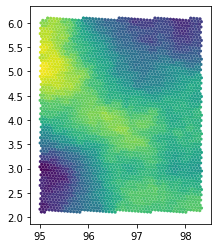

In [30]:
gdf_no_area_lg_def = get_h3_vector_statistics(
    "../../datasets/raw/h3_raster_QA_calculations/preprocessed/def_area_kernnel.tif",
    f"{FILE_DIR}/satelligence data/AcehMills_indicators_50kmbuffer.shp",
    column='def_estimated_count',
    resolution=6)
#save
gdf_no_area_lg_def.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/lg_def_no_area_ha_h3.csv")
gdf_no_area_lg_def.head()

,FID,geometry,sum
0,0,"POLYGON ((98.47767 2.24508, 98.47550 2.20109, ...",143.095114
1,1,"POLYGON ((98.44488 2.31416, 98.44271 2.27017, ...",169.505203
2,2,"POLYGON ((98.40582 2.39111, 98.40366 2.34712, ...",197.194828
3,3,"POLYGON ((98.36445 2.43594, 98.36228 2.39195, ...",216.081869
4,4,"POLYGON ((98.51418 2.45678, 98.51201 2.41279, ...",185.922822


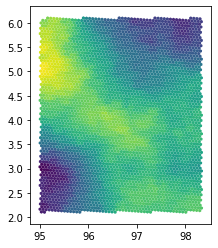

In [26]:
#get corrected data stadistics

gdf_area_lg_def = get_zonal_stats_correction_factor(raster_path="../../datasets/raw/h3_raster_QA_calculations/preprocessed/def_area_kernnel.tif",
                                      corrected_area_gdf=area_h3_gdf,
                                      resolution=6,
                                      buffer_gdf=gdf_buffer50km,
                                      formula=1)
gdf_area_lg_def.to_csv("../../datasets/raw/h3_raster_QA_calculations/statistics/lg_def_area_ha_h3.csv")

gdf_area_lg_def.head()